# **Collaborative Filtering**

# **Dataset Description: `ratings2k.csv`**
**This dataset contains product rating information, with 2365 data samples and the following columns:**

| Column Name | Description             | Data Type | Example     |
|-------------|--------------------------|-----------|-------------|
| `index`     | Row index                | Integer   | 0, 1, 2...   |
| `user`      | User ID                  | String    | 73, 36, 72...  |
| `item`      | Product ID               | String    | 52, 239, 26...  |
| `rating`    | Rating (from 0.0 to 5.0) | Float     | 4, 3, 1...    |


In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import avg, sqrt, sum as spark_sum, desc
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import pow as spark_pow, sqrt, avg
from pyspark.sql.functions import abs as spark_abs
import matplotlib.pyplot as plt
import seaborn as sns

## **Algorithms**
Implement the Collaborative Filtering algorithm to recommend items for individual

users using PySpark. It should be a class for future deployment.
The similarity between users is measured using the Pearson correlation coefficient.

The constructor takes in the value of N (number of similar users) and the data set as a data frame (PySpark).

The function predict() takes in a user (a vector of ratings) and the expected number of recommended items. It returns a data frame (PySpark) consisting of recommended items sorted in the descending order of scores.

## **Experiments**
Load the given dataset to construct the utility matrix and then infer “profile” vectors for users and items.

Divide the dataset into a training and test sets with the ratio of 8 : 2.

Evaluate the algorithm in the test set with N in the range [2, 16]. After that, draw a bar chart to illustrate the RMSE values for each N.

### **Khởi tạo SparkSession và đọc dữ liệu**


SparkSession được tạo với tên ứng dụng là "CollaborativeFiltering_Pearson".

Dữ liệu được đọc từ Google Drive với tùy chọn header=True để sử dụng dòng đầu làm tiêu đề, và inferSchema=True để tự động suy luận kiểu dữ liệu.

Chỉ giữ lại 3 cột: user, item và rating để phục vụ cho bài toán Collaborative Filtering.

In [ ]:
# Khởi tạo Spark session
spark = SparkSession.builder \
    .appName("CollaborativeFiltering_Pearson") \
    .getOrCreate()

# Đọc dữ liệu
df = spark.read.csv("/content/drive/MyDrive/ratings2k.csv", header=True, inferSchema=True)

# Chọn các cột quan trọng
df = df.select("user", "item", "rating")


### **Phân tích dữ liệu người dùng và lọc người dùng không khách quan**

Người dùng không khách quan được xác định là:

* Chỉ sử dụng một mức đánh giá (thiếu khách quan).

* Hoặc đánh giá quá ít (≤ 2 sản phẩm).

Phân tích này giúp làm sạch dữ liệu trước khi áp dụng các thuật toán để tránh bias trong mô hình.

In [ ]:
# Tổng số dòng
total_rows = df.count()

# Tổng số người dùng
total_users = df.select("user").distinct().count()

# "Người dùng không khách quan" là người đánh giá quá ít hoặc chỉ toàn 1 giá trị
# Đếm số người dùng với < 3 lượt đánh giá hoặc có rating không đa dạng

# user_behavior = df.groupBy("user").agg(
#     countDistinct("rating").alias("distinct_ratings"),
#     countDistinct("item").alias("num_rated_items"),

# )

# biased_users = user_behavior.filter(
#     (col("distinct_ratings") == 1) | (col("num_rated_items") <= 2)
# )

# num_biased_users = biased_users.count()
# biased_percent = (num_biased_users / total_users) * 100

# In kết quả
print(f"Tổng số dòng dữ liệu: {total_rows}")
print(f"Tổng số người dùng: {total_users}")
# print(f"Số người dùng đánh giá không khách quan: {num_biased_users}")
# print(f"Tỉ lệ phần trăm: {biased_percent:.2f}%")



Tổng số dòng dữ liệu: 2365
Tổng số người dùng: 74


### **Lớp `CollaborativeFiltering`: Dự đoán đánh giá bằng lọc cộng tác dựa trên Pearson**

Chuẩn hóa đánh giá để tính Pearson giữa người dùng.

Chọn Top-N người dùng tương tự nhất cho mỗi người dùng cần dự đoán.

Dự đoán đánh giá dựa trên đánh giá của hàng xóm có trọng số theo độ tương quan.

In [ ]:
class CollaborativeFiltering:
    def __init__(self, df, N, similarity_threshold):
        self.df = df # Dữ liệu đánh giá đầu vào
        self.N = N  # Số lượng hàng xóm tương tự hàng đầu
        self._prepare()  # Chuẩn bị dữ liệu và tính toán hệ số tương quan
        self.similarity_threshold = similarity_threshold  # Ngưỡng tương quan Pearson tối thiểu


    def _prepare(self):
        # Tính trung bình mỗi user
        user_avg = self.df.groupBy("user").agg(avg("rating").alias("avg_rating"))

        # Chuẩn hóa rating bằng cách trừ trung bình
        normalized = self.df.join(user_avg, "user")
        normalized = normalized.withColumn("norm_rating", col("rating") - col("avg_rating"))

        # Tạo cặp user-user có cùng item
        pair_ratings = normalized.alias("a").join(
            normalized.alias("b"),
            (col("a.item") == col("b.item")) & (col("a.user") < col("b.user"))
        )

        # Tính các thành phần của công thức Pearson
        pair_scores = pair_ratings.select(
            col("a.user").alias("user1"),
            col("b.user").alias("user2"),
            (col("a.norm_rating") * col("b.norm_rating")).alias("product"),
            col("a.norm_rating").alias("r1"),
            col("b.norm_rating").alias("r2")
        )

        # Tính hệ số Pearson giữa các cặp người dùng
        self.similarity_df = pair_scores.groupBy("user1", "user2").agg(
            spark_sum("product").alias("numerator"),
            sqrt(spark_sum(col("r1")**2)).alias("denom1"),
            sqrt(spark_sum(col("r2")**2)).alias("denom2")
        ).withColumn(
            "pearson", col("numerator") / (col("denom1") * col("denom2"))
        ).filter(col("pearson").isNotNull())

    def predict_all(self, test_df, num_recommendations):
        # Tính trung bình rating của từng user
        user_avg = self.df.groupBy("user").agg(avg("rating").alias("avg_rating"))

        # Lấy danh sách người dùng trong test set
        test_users = test_df.select("user").distinct()

        # Tìm các user tương tự (pearson > threshold)
        sim_df = test_users.join(
            self.similarity_df,
            test_users.user == self.similarity_df.user1,
            how="inner"
        ).select(
            col("user1").alias("target_user"),
            "user2",
            "pearson"
        )

        # Lấy top-N người dùng tương tự
        window_spec = Window.partitionBy("target_user").orderBy(col("pearson").desc())
        topN_sim_df = sim_df.withColumn("rank", row_number().over(window_spec))\
                            .filter((col("rank") <= self.N) & (col("pearson") > self.similarity_threshold))\
                            .drop("rank")

        # Ghép với bảng đánh giá của người tương tự
        sim_ratings = topN_sim_df.join(
            self.df,
            self.df.user == topN_sim_df.user2,
            how="inner"
        ).join(
            user_avg.withColumnRenamed("user", "sim_user"),
            col("sim_user") == col("user2"),
            how="inner"
        ).select(
            "target_user", "item", "rating", "pearson", col("avg_rating").alias("sim_user_avg")
        )

        # Tính rating chuẩn hóa và dự đoán
        norm_preds = sim_ratings.withColumn("norm_rating", col("rating") - col("sim_user_avg"))\
            .withColumn("weighted", col("norm_rating") * col("pearson"))\
            .groupBy("target_user", "item")\
            .agg(
                spark_sum("weighted").alias("numerator"),
                spark_sum(spark_abs(col("pearson"))).alias("denominator")
            ).filter(col("denominator") != 0)\
            .withColumn("predicted_norm_rating", col("numerator") / col("denominator"))

        # Cộng lại trung bình người dùng cần dự đoán để khôi phục rating
        preds = norm_preds.join(
            user_avg.withColumnRenamed("user", "target_user"),
            on="target_user",
            how="inner"
        ).withColumn(
            "predicted_rating",
            col("predicted_norm_rating") + col("avg_rating")
        ).select(
            col("target_user").alias("user"),
            "item",
            "predicted_rating"
        )

        # Lấy top-N sản phẩm được dự đoán cao nhất cho mỗi user
        rank_spec = Window.partitionBy("user").orderBy(col("predicted_rating").desc())

        topN_preds = preds.withColumn("rank", row_number().over(rank_spec))\
                          .filter(col("rank") <= num_recommendations)\
                          .drop("rank")

        return topN_preds

    # def predict_all(self, test_df):
    #     # Danh sách người dùng cần dự đoán
    #     test_users = test_df.select("user").distinct()

    #     # Ghép với bảng tương tự để tìm các người dùng tương tự
    #     sim_df = test_users.join(
    #         self.similarity_df,
    #         test_users.user == self.similarity_df.user1,
    #         how="inner"
    #     ).select(
    #         col("user1").alias("target_user"),
    #         "user2",
    #         "pearson"
    #     )

    #     # Lấy top-N người dùng tương tự nhất (Pearson > self.similarity_threshold)
    #     window_spec = Window.partitionBy("target_user").orderBy(col("pearson").desc())
    #     topN_sim_df = sim_df.withColumn("rank", row_number().over(window_spec))\
    #                         .filter((col("rank") <= self.N) & (col("pearson") > self.similarity_threshold))\
    #                         .drop("rank")

    #     # Ghép với bảng đánh giá gốc để lấy đánh giá của hàng xóm
    #     sim_ratings = topN_sim_df.join(
    #         self.df,
    #         self.df.user == topN_sim_df.user2,
    #         how="inner"
    #     ).select(
    #         "target_user", "item", "rating", "pearson"
    #     )

    #     # Tính toán rating dự đoán theo công thức trung bình có trọng số
    #     preds = sim_ratings.withColumn("weighted", col("rating") * col("pearson"))\
    #         .groupBy("target_user", "item")\
    #         .agg(
    #             spark_sum("weighted").alias("numerator"),
    #             spark_sum("pearson").alias("denominator")
    #         ).filter(col("denominator") != 0)\
    #         .withColumn("predicted_rating", col("numerator") / col("denominator"))\
    #         .select(
    #             col("target_user").alias("user"),
    #             "item",
    #             "predicted_rating"
    #         )

    #     return preds

### **Hàm `compute_rmse`: Đánh giá mô hình bằng RMSE**


Tính sai số căn phương bình phương trung bình (Root Mean Squared Error – RMSE) giữa giá trị dự đoán và thực tế.

In [ ]:
def compute_rmse(pred_df, test_df):
    joined = pred_df.join(
        test_df.select("user", "item", "rating"),
        on=["user", "item"],
        how="inner"
    ).withColumn(
        "squared_error", spark_pow(col("predicted_rating") - col("rating"), 2)
    )

    rmse = joined.select(sqrt(avg("squared_error")).alias("rmse")).collect()[0]["rmse"]
    return rmse


### **Đánh giá mô hình Collaborative Filtering với các giá trị Top-N**

In [ ]:
# Chia tập train/test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Training set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")

rmse_results = []

# Lặp qua các giá trị N từ 2 đến 16 để tìm số hàng xóm tối ưu
for N in range(2, 17):
    print(f"N = {N}")
    model = CollaborativeFiltering(train_df, N, 0.5) # Khởi tạo mô hình
    pred_df = model.predict_all(test_df, num_recommendations=5)
    rmse = compute_rmse(pred_df, test_df) # Tính RMSE
    print(f"RMSE = {rmse:.4f}")
    rmse_results.append((N, rmse))


Training set size: 1949
Test set size: 416
N = 2
RMSE = 1.1164
N = 3
RMSE = 1.0520
N = 4
RMSE = 0.9403
N = 5
RMSE = 1.5054
N = 6
RMSE = 1.6055
N = 7
RMSE = 1.7962
N = 8
RMSE = 1.4995
N = 9
RMSE = 1.4995
N = 10
RMSE = 1.6245
N = 11
RMSE = 1.4976
N = 12
RMSE = 1.4976
N = 13
RMSE = 1.6245
N = 14
RMSE = 1.6245
N = 15
RMSE = 1.7513
N = 16
RMSE = 1.7513


In [ ]:
best_N, best_rmse = min(rmse_results, key=lambda x: x[1])
print(f"\nGiá trị N tối ưu là {best_N} với RMSE thấp nhất = {best_rmse:.4f}")


Giá trị N tối ưu là 4 với RMSE thấp nhất = 0.9403


In [ ]:
# --- DEMO PREDICTION FOR SPECIFIC USERS (PySpark only) ---

# Lấy top-N là giá trị có RMSE thấp nhất
best_N = min(rmse_results, key=lambda x: x[1])[0]
print("\n--- DEMO PREDICTION FOR SPECIFIC USERS ---\n")

model = CollaborativeFiltering(train_df, best_N, 0.5)
pred_df = model.predict_all(test_df, num_recommendations=10)  # Dự đoán nhiều hơn để loại bỏ trùng

# Lặp qua một số user cụ thể
for user_id in [1, 2, 3]:
    print(f"Recommendations for User {user_id}:")

    # Lấy các đánh giá thực tế của user từ test set
    user_ratings = test_df.filter(col("user") == user_id)
    num_rated = user_ratings.count()
    print(f"User has already rated {num_rated} items")

    if num_rated > 0:
        print("Sample of user's ratings:")
        user_ratings.select("item", "rating").show(3, truncate=False)
    else:
        print("No ratings found in test set.")

    # Lấy danh sách item đã đánh giá để loại khỏi gợi ý
    rated_items = [row["item"] for row in user_ratings.select("item").collect()]

    # Gợi ý các item chưa đánh giá (đã loại trừ) và in top 5
    recs = pred_df.filter(
        (col("user") == user_id) & (~col("item").isin(rated_items))
    ).orderBy(col("predicted_rating").desc())

    print("\nTop 5 recommended items:")
    recs.select("item", "predicted_rating").show(5, truncate=False)

    print("-" * 40)



--- DEMO PREDICTION FOR SPECIFIC USERS ---

Recommendations for User 1:
User has already rated 1 items
Sample of user's ratings:
+----+------+
|item|rating|
+----+------+
|168 |5.0   |
+----+------+


Top 5 recommended items:
+----+-----------------+
|item|predicted_rating |
+----+-----------------+
|199 |5.654761904761905|
|176 |5.654761904761905|
|301 |5.248809523809523|
|322 |5.154761904761905|
|36  |5.072883597883598|
+----+-----------------+
only showing top 5 rows

----------------------------------------
Recommendations for User 2:
User has already rated 6 items
Sample of user's ratings:
+----+------+
|item|rating|
+----+------+
|42  |0.5   |
|81  |4.0   |
|148 |1.0   |
+----+------+
only showing top 3 rows


Top 5 recommended items:
+----+-----------------+
|item|predicted_rating |
+----+-----------------+
|386 |4.745995423340961|
|373 |4.745995423340961|
|128 |4.745995423340961|
|119 |4.745995423340961|
|89  |4.745995423340961|
+----+-----------------+
only showing top 5 rows

### **Trực quan hóa mối quan hệ giữa số hàng xóm (N) và sai số RMSE**

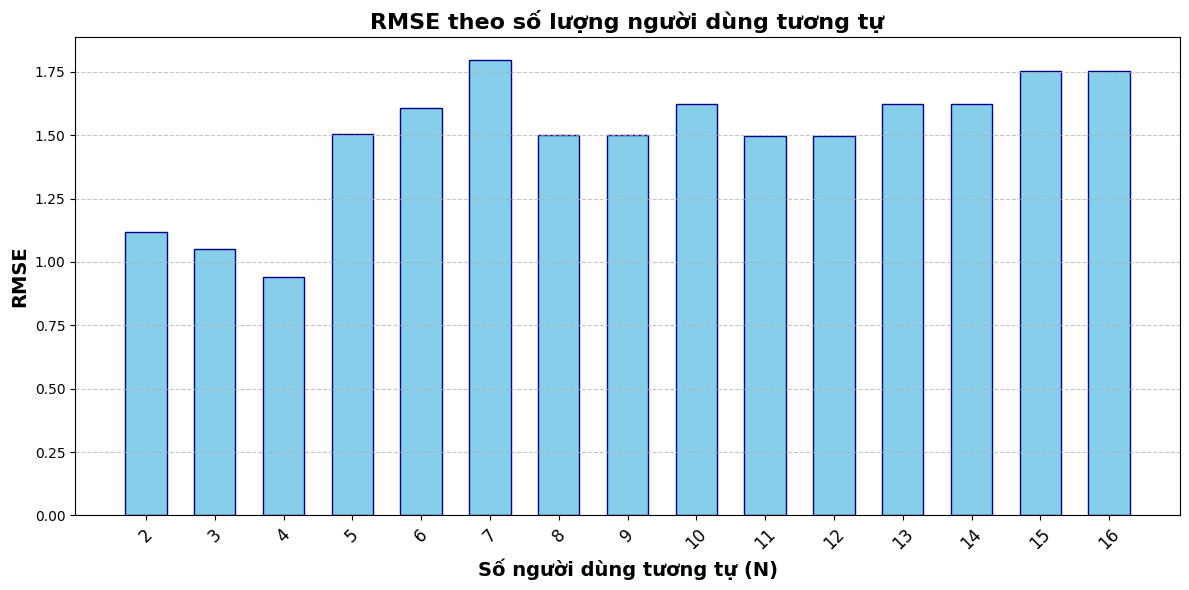

In [ ]:
# Dữ liệu từ kết quả RMSE
ns, rmses = zip(*rmse_results)

plt.figure(figsize=(12, 6))

plt.bar(ns, rmses, color="skyblue", width=0.6, edgecolor='darkblue')

# Thiết lập nhãn cho các trục
plt.xlabel("Số người dùng tương tự (N)", fontsize=14, fontweight='bold')
plt.ylabel("RMSE", fontsize=14, fontweight='bold')

# Thiết lập tiêu đề
plt.title("RMSE theo số lượng người dùng tương tự", fontsize=16, fontweight='bold')

# Điều chỉnh nhãn trục x và đường lưới
plt.xticks(ns, fontsize=12, rotation=45)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
